# Finding a New Pet Store Location in St. Paul, MN  
> Using k-means clustering in finding a new Pet Store location using Yelp and FourSquare API. _The original analysis was done in [September 2019](https://github.com/atunanggara/Coursera_Capstone/tree/master/Capstone-PetStore) and updated on May 2020 for blog publication._  
   

- toc: true  
- badges: true  
- comments: true  
- categories: [portfolio, jupyter, unlabeled data]
- image: images/thumbnails/elbow_method_k-means.png  
- permalink: /portfolio/:year/:month/:day/:title
- hide: true  
- search_exclude: true  

# Summary  

I recommend Juan Doe to open up a new pet store in three different zip codes around the St. Paul, MN region:  
1. First is the [Macalester-Groveland neighborhood](https://www.unitedstateszipcodes.org/55105/) (55105).  
They have high median income with many pet services and only one other pet store in the area. In order to succeed, John Doe needs to make sure that the type of items sold in the pet stores are different enough than the ones sold in grocery stores and the other pet store.  

2. Second is the [Falcon Heights area](https://www.unitedstateszipcodes.org/55108/) (55108).  
They do not have a pet store, but veterinarian hospitals and animal shelters are in the area. 

3. Third is the [Battle Creek neighborhood](https://www.unitedstateszipcodes.org/55119/) (55119).  
They have a similar make up as the Falcon Heights and a dog park nearby. 

## Introduction 

Sometime on March 2019, my wife and I decided to adopt a 10 year old dog named Filbert from the Animal Humane Society. Here is him in his natural habitat:  

<img src="../images/jupyter_posts/pet_store/Filbert_rectangle.jpg" style="width: 300px;"/>


To ensure his happiness, we go to pet stores in our area for foods and treats quite regularly. On the other hand, I have also been trying to brush up on my k-means clustering algorithm understanding via IBM data science specialization. So I took it upon myself to do some research and came up with finding a new pet store location around St. Paul, MN area for my capstone project.   

Unbeknown to me, US residents spent [more than $36 billion](https://www.americanpetproducts.org/press_industrytrends.asp) for pet food and treats in 2019. So, pet store is a lucrative business to get into. 


## Target Audience

Our friend, Juan Doe, wants to open a new pet store in St. Paul, MN area, and has asked me to help finding a location for it. Cost of doing business in a metropolis city like St. Paul can be stratospheric. Therefore, market share analysis can be helpful in figuring out a good location / locations and reduce the risk of opening a store in a saturated area. 

## Data and Methodology

To run the analysis, I pulled several data from various sources: 

- Zipcode data from [uszipcode](https://uszipcode.readthedocs.io/index.html#) Python package.  
It provides data for the **latitude and longitude** of all zipcode in the St. Paul, MN area along with the **median household income**.

In [30]:
# hide 
import pandas as pd
import numpy as np
from uszipcode import SearchEngine
from geopy.geocoders import Nominatim 
import altair as alt
import requests
import json 

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import folium 

In [2]:
#hide
# using the uszipcode python package
searchzip = SearchEngine(simple_zipcode=False) # set simple_zipcode=False to use rich info database
# get the zip code from the surrounding St. Paul, MN area:
res = searchzip.by_city_and_state("Saint Paul", "MN", returns=40)
# Let's create a dataframe containing all the zipcodes for St. Paul, MN area:
zipStPaul = pd.DataFrame(columns = ['zipcode','med_income','latitude','longitude'])
for data in res:
    zipStPaul = zipStPaul.append({'zipcode': data.zipcode,
                                 'med_income': data.median_household_income,
                                 'latitude': data.lat,
                                 'longitude': data.lng},
                                 ignore_index=True)

In [3]:
#hide_input
zipStPaul.head()

,zipcode,med_income,latitude,longitude
0,55101,40300,44.95,-93.09
1,55102,46255,44.93,-93.12
2,55103,28899,44.97,-93.13
3,55104,44629,44.96,-93.17
4,55105,76472,44.93,-93.16


In [4]:
#hide
zipStPaul.shape

(30, 4)

In [57]:
#hide
mn_zipcode = "https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/mn_minnesota_zip_codes_geo.min.json"
mn_json = requests.get(mn_zipcode).json()
mn_zip = pd.json_normalize(mn_json['features'])
mn_zip = mn_zip[["properties.ZCTA5CE10","geometry.coordinates"]]
mn_zip.columns = ['zipcode','topojson']
# mn_zip.head()

In [56]:
#hide
stpaul_zip_merge = pd.merge(zipStPaul, mn_zip, on='zipcode')
stpaul_zip_merge.head()

,zipcode,med_income,latitude,longitude,topojson
0,55101,40300,44.95,-93.09,"[[[-93.099277, 44.950702], [-93.099357, 44.950..."
1,55102,46255,44.93,-93.12,"[[[-93.126235, 44.943427], [-93.126245, 44.944..."
2,55103,28899,44.97,-93.13,"[[[-93.126327, 44.95163], [-93.126328, 44.9518..."
3,55104,44629,44.96,-93.17,"[[[-93.126327, 44.95163], [-93.126325, 44.9512..."
4,55105,76472,44.93,-93.16,"[[[-93.150174, 44.926947], [-93.15172, 44.9269..."


In [58]:
stpaul_zip_merge.shape

(30, 5)

In [59]:
json_zip_stpaul = stpaul_zip_merge.to_json(orient='split')

In [65]:
# mn_zipcodes = alt.topo_feature(url=json_zip_stpaul, feature='')

# background = alt.Chart(mn_zipcodes).mark_geoshape(
#     stroke='black'
# ).encode(
#     tooltip=['zipcode:N'],
# ).properties(
#     width=500,
#     height=350,
#     title=f'MN Zip Code'
# ).project('albersUsa')

# background
# background
# .transform_lookup(
#     lookup='properties.ZCTA5CE10',
#     from_=alt.LookupData(data=zipStPaul,key='zipcode',
#                          fields=['zipcode','med_income'])
# ).encode(
#     color=alt.Color('med_income:Q',scale=alt.Scale(scheme='greenblue')),
#     tooltip=['zipcode:Q','med_income:Q'],
# )
# .transform_lookup(
#     lookup='properties.ZCTA5CE10',
#     from_=alt.LookupData(data=dfmnlatest,key='fips',
#                          fields=['county','cases','deaths','date'])
# )

To visualize the data, we are going to use choropleth map

There are **thirty zip code** data that can be used for the FourSquare Places API.  
We will use _folium_ Python package to visualize the data:

First, we use geopy library to get the latitude and longitude values of St Paul, MN.

In [43]:
#hide
address = 'Saint Paul, MN'

geolocator = Nominatim(user_agent="spaul_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# print('The geograpical coordinate of St Paul, MN are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of St Paul, MN are 44.9504037, -93.1015026.


In [44]:
#hide_input
# create map of St. Paul using latitude and longitude values
map_stPaul = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, zipcode, medincome in zip(zipStPaul['latitude'], zipStPaul['longitude'], zipStPaul['zipcode'],zipStPaul['med_income']):
    label = '{}, {}'.format(zipcode, medincome)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stPaul)  
    
map_stPaul

In [66]:
# map_stPaul = folium.Map(location=[latitude, longitude], zoom_start=10)

# folium.Choropleth(
#     geo_data=mn_zipcode,
#     name='MN zip code',
# ).add_to(map_stPaul)

# folium.LayerControl().add_to(map_stPaul)

# map_stPaul

#### Removing zip codes that are far awar from St. Paul area

I am going to remove zip codes that are far away from the St. Paul area:  
``55109``, ``55110``, ``55111``, ``55112``, ``55115``, ``55118``, ``55120``, ``55121``, ``55122``, ``55123``, ``55124``, ``55125``, ``55126``,``55127``,``55128``, ``55129``

In [10]:
dropziplist = ['55109','55110','55111','55112', 
               '55115', '55118', '55120', '55121', 
               '55122', '55123', '55124', '55125', 
               '55126','55127','55128', '55129']

zipStPaul = zipStPaul[~zipStPaul['zipcode'].isin(dropziplist)]

In [11]:
# saving the dataframe for presentation
zipStPaul.to_csv('zipStPaul.csv',index=False)

## FourSquare data from FourSquare [Places API](https://developer.foursquare.com/docs/api). 

I will utilize the explore function to get venue recommendations and zone in on the pet related categories (e.g. pet store, dog park, dog friendly restaurants) 

In [12]:
# get the ID and secret from the obfuscated file 
CLIENT_ID = pd.read_csv('../../Coursera_Capstone/FSclientID.txt',header=None)[0][0] # your Foursquare ID
CLIENT_SECRET = pd.read_csv('../../Coursera_Capstone/FSclientSecret.txt',header=None)[0][0] # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [13]:
# modified from previous work:
def getNearbyVenues(zipcode, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for zipcode, lat, lng in zip(zipcode, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        results2 = results["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            results['response']['headerLocation'], 
            zipcode,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['location'].get('postalCode',0),
            v['venue']['categories'][0]['name']) for v in results2])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Zipcode',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude',
                             'Venue Zipcode',
                             'Venue Category']
    
    return(nearby_venues)

In [14]:
LIMIT = 100

In [16]:
stpaul_venues = getNearbyVenues(zipcode=zipStPaul['zipcode'],latitudes=zipStPaul['latitude'],
                               longitudes=zipStPaul['longitude'],
                               radius=4000)

In [17]:
stpaul_venues.head()

,Neighborhood,Zipcode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Zipcode,Venue Category
0,Saint Paul,55101,44.95,-93.09,Barrel Theory Beer Company,44.951021,-93.088258,55101,Brewery
1,Saint Paul,55101,44.95,-93.09,Mears Park,44.949371,-93.087920,55101,Park
2,Saint Paul,55101,44.95,-93.09,The Buttered Tin,44.950857,-93.088679,55101,Bakery
3,Saint Paul,55101,44.95,-93.09,CHS Field,44.950619,-93.084789,55101,Baseball Stadium
4,Saint Paul,55101,44.95,-93.09,St. Paul Farmers' Market,44.949620,-93.085131,55101,Farmers Market


In [18]:
stpaul_venues.shape

(1400, 9)

#### Cleaning up the `petstpaul_venues` data

I clean up the stpaul_venues data through the following methods:  
- Based on the `Venue` column, separate the unique and duplicated values into two
- In unique dataframe, fill in the `Venue Zipcode` column with the `Zipcode` column 
- In duplicated dataframe, separate them into zero `Venue Zipcode` and non-zero `Venue Zipcode` dataframe:
    - for non-zero `Venue Zipcode` dataframe, only keep the values where `Venue Zipcode` and `Zipcode` column matches
    - for zero `Venue Zipcode` dataframe, search manually and fill in the missing zipcode value

##### Separate the unique and duplicated values into two:

In [19]:
unique_stpaul_venues = stpaul_venues[~stpaul_venues.duplicated(subset='Venue',keep=False)]
duplicated_stpaul_venues = stpaul_venues[stpaul_venues.duplicated(subset='Venue',keep=False)]

##### In unique dataframe, fill in the `Venue Zipcode` column with the `Zipcode` column 

In [20]:
unique_stpaul_venues = unique_stpaul_venues.reset_index(drop=True)
for i in range(len(unique_stpaul_venues)):
    if unique_stpaul_venues.loc[i,'Venue Zipcode'] == 0:
        unique_stpaul_venues.loc[i,'Venue Zipcode'] = unique_stpaul_venues.loc[i,'Zipcode']

##### In duplicated dataframe, separate them into zero `Venue Zipcode` and non-zero `Venue Zipcode` dataframe:

In [29]:
duplicated_stpaul_venues = duplicated_stpaul_venues.sort_values(by='Venue')
zero_duplicated_stpaul_venues = duplicated_stpaul_venues[duplicated_stpaul_venues['Venue Zipcode']==0]
nonzero_duplicated_stpaul_venues = duplicated_stpaul_venues[~(duplicated_stpaul_venues['Venue Zipcode']==0)]

##### for non-zero `Venue Zipcode` dataframe, only keep the values where `Venue Zipcode` and `Zipcode` column matches

In [30]:
nonzero_duplicated_stpaul_venues = nonzero_duplicated_stpaul_venues.reset_index(drop=True)
nonzero_duplicated_stpaul_venues = nonzero_duplicated_stpaul_venues[
    nonzero_duplicated_stpaul_venues['Zipcode']==nonzero_duplicated_stpaul_venues['Venue Zipcode']]

##### for zero `Venue Zipcode` dataframe, search manually and fill in the missing zipcode value

In [31]:
zero_duplicated_stpaul_venues = zero_duplicated_stpaul_venues.reset_index(drop=True)
zero_duplicated_stpaul_venues.shape

(33, 9)

In [35]:
zero_duplicated_stpaul_venues.loc[29:33]

,Neighborhood,Zipcode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Zipcode,Venue Category
29,Saint Paul,55106,44.94,-93.05,Subtext Books,44.945629,-93.094695,0,Bookstore
30,Saint Paul,55130,44.97,-93.09,Subtext Books,44.945629,-93.094695,0,Bookstore
31,Saint Paul,55107,44.93,-93.09,Subtext Books,44.945629,-93.094695,0,Bookstore
32,Saint Paul,55101,44.95,-93.09,Subtext Books,44.945629,-93.094695,0,Bookstore


In [36]:
# Carl's Gizmo
zero_duplicated_stpaul_venues.at[1,'Venue Zipcode'] = '55108'
# Falcon Heights Community Park
zero_duplicated_stpaul_venues.at[3,'Venue Zipcode'] = '55113'
# Leinie Lodge Bandshell
zero_duplicated_stpaul_venues.at[6,'Venue Zipcode'] = '55108'
# Lulu's Public House
zero_duplicated_stpaul_venues.at[8,'Venue Zipcode'] = '55108'
# machinery hills
zero_duplicated_stpaul_venues.at[13,'Venue Zipcode'] = '55108'
# mighty midway
zero_duplicated_stpaul_venues.at[17, 'Venue Zipcode'] = '55113'
# minneaple pie
zero_duplicated_stpaul_venues.at[19, 'Venue Zipcode'] = '55108'
# real meal deli
zero_duplicated_stpaul_venues.at[24, 'Venue Zipcode'] = '55101'
# redbox - Maplewood
zero_duplicated_stpaul_venues.at[26, 'Venue Zipcode'] = '55117'
# redbox - St Paul
zero_duplicated_stpaul_venues.at[27, 'Venue Zipcode'] = '55119'
# redbox - Maplewood
zero_duplicated_stpaul_venues.at[28, 'Venue Zipcode'] = '55117'
# subtext books
zero_duplicated_stpaul_venues.at[29, 'Venue Zipcode'] = '55102'
# subtext books
zero_duplicated_stpaul_venues.at[29, 'Zipcode'] = '55102'

zero_duplicated_stpaul_venues = zero_duplicated_stpaul_venues[
    zero_duplicated_stpaul_venues['Zipcode']==zero_duplicated_stpaul_venues['Venue Zipcode']]

In [37]:
zero_duplicated_stpaul_venues

,Neighborhood,Zipcode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Zipcode,Venue Category
1,Falcon Heights,55108,44.98,-93.18,Carl's Gizmo,44.986444,-93.169245,55108,Sandwich Place
3,Roseville,55113,45.01,-93.16,Falcon Heights Community Park,44.998524,-93.185745,55113,Park
6,Falcon Heights,55108,44.98,-93.18,Leinie Lodge Bandshell - Minnesota State Fair,44.979990,-93.168811,55108,Concert Hall
8,Falcon Heights,55108,44.98,-93.18,Lulu's Public House,44.981229,-93.177533,55108,Southern / Soul Food Restaurant
13,Falcon Heights,55108,44.98,-93.18,Machinery Hill - Minnesota State Fair,44.985519,-93.169700,55108,Electronics Store
17,Roseville,55113,45.01,-93.16,Mighty Midway,44.980074,-93.175349,55113,Theme Park Ride / Attraction
19,Falcon Heights,55108,44.98,-93.18,Minneapple Pie,44.978595,-93.171173,55108,Diner
24,Saint Paul,55101,44.95,-93.09,Real Meal Delicatessen,44.947036,-93.090568,55101,American Restaurant
26,Maplewood,55117,45.00,-93.10,Redbox,44.976818,-93.067060,55117,Video Store
27,Saint Paul,55119,44.94,-93.01,Redbox,44.962580,-92.984799,55119,Video Store


##### Combining them all back

In [38]:
stpaul_venues = pd.concat([nonzero_duplicated_stpaul_venues,zero_duplicated_stpaul_venues, unique_stpaul_venues])

##### Ensuring the venues are all located in St. Paul region zipcode

In [39]:
# set Venue Zipcode column into integer so that I can sort it by values
stpaul_venues['Venue Zipcode'] = stpaul_venues['Venue Zipcode'].astype(int)
# sort by Venue Zipcode value
stpaul_venues = stpaul_venues.sort_values(by='Venue Zipcode')
# ensure that venues are located in the zipStPaul['zipcode']
stpaul_venues = stpaul_venues[stpaul_venues['Venue Zipcode'].isin(zipStPaul['zipcode'])]
# reset the index
stpaul_venues = stpaul_venues.reset_index(drop=True)
# see what the shape look like
stpaul_venues.shape

(562, 9)

##### Let's save the queries into a csv file:

In [40]:
stpaul_venues.to_csv('stpaul_venues.csv',index=False)

##### Let's inspect the different categories

In [41]:
stpaul_venues['Venue Category'].unique()

array(['Pizza Place', 'Southern / Soul Food Restaurant', 'Dessert Shop',
       'Brewery', 'New American Restaurant', 'Breakfast Spot',
       'Baseball Stadium', 'Gym / Fitness Center', 'Dive Bar',
       'Asian Restaurant', 'Train Station', 'Sandwich Place', 'Bakery',
       'Liquor Store', 'Coffee Shop', 'Hotel', 'Farmers Market',
       'Theater', 'Gym', 'Thai Restaurant', 'Café', 'Supermarket', 'Bar',
       'Beer Bar', 'Trail', 'American Restaurant', 'Park',
       'Italian Restaurant', 'Non-Profit', 'Mexican Restaurant', 'Spa',
       'Restaurant', 'French Restaurant', 'Lounge', 'Scenic Lookout',
       'Museum', "Men's Store", 'Movie Theater', 'Performing Arts Venue',
       'Eastern European Restaurant', 'Organic Grocery', 'Music Venue',
       'Cocktail Bar', 'History Museum', 'Diner', 'Athletics & Sports',
       'Steakhouse', 'Burger Joint', 'Sporting Goods Shop', 'Market',
       'Science Museum', 'Wine Shop', 'Dog Run', 'Gastropub',
       'Donut Shop', 'Residential Build

Category of interests are:  
- Dog Run
- Pet Store
- Veterinarian

How many of them are there in the dataset?

In [42]:
# listing all the category of interest:
catInt = ['Dog Run','Pet Store','Veterinarian']
# subsetting the data
justpetfoursquare= stpaul_venues[stpaul_venues['Venue Category'].isin(catInt)]
# resetting the index:
justpetfoursquare = justpetfoursquare.reset_index(drop=True)
justpetfoursquare

,Neighborhood,Zipcode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Zipcode,Venue Category
0,Saint Paul,55102,44.93,-93.12,High Bridge Dog Park,44.935525,-93.106320,55102,Dog Run
1,Roseville,55113,45.01,-93.16,Chuck & Don's Pet Food Outlet,45.024081,-93.169918,55113,Pet Store
2,Saint Paul,55114,44.97,-93.20,Twin Cities Reptiles,44.963767,-93.196522,55114,Pet Store
3,Saint Paul,55116,44.91,-93.17,Chuck & Don's Pet Food Outlet,44.916832,-93.189630,55116,Pet Store
4,Saint Paul,55116,44.91,-93.17,Petco,44.918520,-93.196697,55116,Pet Store
5,Maplewood,55117,45.00,-93.10,Como Park Animal Hospital,44.971809,-93.125984,55117,Veterinarian
6,Saint Paul,55119,44.94,-93.01,Battle Creek Dog Park,44.939410,-93.001641,55119,Dog Run
7,Saint Paul,55130,44.97,-93.09,Arlington Arkwright Dog Park,44.982032,-93.083346,55130,Dog Run


There are only 8 values and there should be more. So, I will augment the values from FourSquare API with values from **yelp API**.

### Yelp API  

In [43]:
# get the ID and secret from the obfuscated file 
APIkey = pd.read_csv('../../brainstorming/yelp-cred/APIkey',header=None)[0][0] # my yelp APIkey
headers = {'Authorization': 'Bearer %s' % APIkey}

In [44]:
# yelp has a limit of 50 for their query
LIMIT = 50

In [45]:
# modified from the earlier function to match the yelp API
def getQueryVenues(query, zipcode, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for zipcode, lat, lng in zip(zipcode, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.yelp.com/v3/businesses/search?term={}&latitude={}&longitude={}&radius={}&limit={}'.format(
            query,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url, headers=headers).json()['businesses']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            lat, 
            lng, 
            v['name'], 
            v['location']['zip_code'],
            v['coordinates']['latitude'], 
            v['coordinates']['longitude'],  
            v['categories'][0]['title']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['zip_code', 
                  'Zipcode Latitude', 
                  'Zipcode Longitude', 
                  'Venue',
                  'Venue Zipcode',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [46]:
petstpaul_venues = getQueryVenues(query='pet',
                                  zipcode=zipStPaul['zipcode'],
                                  latitudes=zipStPaul['latitude'],
                                  longitudes=zipStPaul['longitude'],
                                  radius=4000)
petstpaul_venues.shape

(660, 8)

In [47]:
# limit only to the zipcode from what we queried in zipStPaul:
petstpaul_venues = petstpaul_venues[petstpaul_venues['Venue Zipcode'].isin(zipStPaul['zipcode'])]

#### Cleaning up the `petstpaul_venues` data

I clean up the `petstpaul_venues` data through the following methods:  
- Based on the `Venue` column, separate the unique and duplicated values into two
- In unique dataframe, they are all set!
- In duplicated dataframe, separate them into rows where `Venue Zipcode` and `Zipcode` are the same and rows where they are not:
    - Keep all the values when `Venue Zipcode` and `Zipcode` are the same
    - Remove the duplicates when `Venue Zipcode` and `Zipcode` are not the same

##### Based on the `Venue` column, separate the unique and duplicated values into two

In [48]:
unique_petstpaul_venues = petstpaul_venues[~petstpaul_venues.duplicated(subset='Venue',keep=False)]
duplicated_petstpaul_venues = petstpaul_venues[petstpaul_venues.duplicated(subset='Venue',keep=False)]
# see the unique values:
unique_petstpaul_venues

,zip_code,Zipcode Latitude,Zipcode Longitude,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
301,55107,44.93,-93.09,The Day Spaw,55107,44.882454,-93.076205,Pet Groomers
382,55113,45.01,-93.16,Metro Pet Spa,55113,45.032089,-93.176186,Pet Sitting
570,55119,44.94,-93.01,Funtastic K9 Training,55119,44.949660,-93.017220,Pet Training
574,55119,44.94,-93.01,Century Animal Clinic,55119,44.966652,-92.985361,Veterinarians


##### In unique dataframe, they are all set!

##### In duplicated dataframe, separate them into rows where `Venue Zipcode` and `Zipcode` are the same and rows where they are not:
##### Keep all the values when `Venue Zipcode` and `Zipcode` are the same

In [49]:
duplicated_petstpaul_venues = duplicated_petstpaul_venues.sort_values(by='Venue')
duplicated_petstpaul_venues = duplicated_petstpaul_venues.reset_index(drop=True)
value_duplicated_petstpaul_venues = duplicated_petstpaul_venues[
    duplicated_petstpaul_venues['zip_code']==duplicated_petstpaul_venues['Venue Zipcode']]
value_duplicated_petstpaul_venues = value_duplicated_petstpaul_venues.reset_index(drop=True)
value_duplicated_petstpaul_venues.shape

(65, 8)

##### Remove the duplicates when `Venue Zipcode` and `Zipcode` are not the same

In [50]:
pickled_duplicated_petstpaul_venues = duplicated_petstpaul_venues[
    ~(duplicated_petstpaul_venues['Venue'].isin(value_duplicated_petstpaul_venues['Venue']))]
pickled_duplicated_petstpaul_venues = pickled_duplicated_petstpaul_venues.drop_duplicates(subset='Venue')
pickled_duplicated_petstpaul_venues

,zip_code,Zipcode Latitude,Zipcode Longitude,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
12,55130,44.97,-93.09,Animal House Pet Styling,55113,45.019765,-93.105945,Pet Services
261,55130,44.97,-93.09,The Woof Room,55113,45.002530,-93.106430,Pet Sitting


##### Combining all the values

In [51]:
petstpaul_venues = pd.concat([unique_petstpaul_venues,
                              value_duplicated_petstpaul_venues, 
                              pickled_duplicated_petstpaul_venues])
petstpaul_venues.shape

(71, 8)

##### resetting the index

In [52]:
petstpaul_venues['Venue Zipcode'] = petstpaul_venues['Venue Zipcode'].astype(int)
petstpaul_venues = petstpaul_venues.sort_values(by='Venue Zipcode')
petstpaul_venues = petstpaul_venues.reset_index(drop=True)

In [53]:
petstpaul_venues['Venue Category'].unique()

array(['Dog Walkers', 'Pet Groomers', 'Veterinarians', 'Pet Sitting',
       'Pet Stores', 'Pet Training', 'Pet Services', 'Animal Shelters',
       'Event Photography', 'Pet Photography', 'Cremation Services',
       'Bird Shops'], dtype=object)

In [54]:
# saving the dataframe for presentation
petstpaul_venues.to_csv('petstpaul_venues.csv',index=False)

In order to make life a bit easier, we are going to focus on dogs and cats services, so the categories that we are going to consider are:
- Dog Walkers
- Veterinarians 
- Pet Groomers
- Pet Sitting
- Pet Stores
- Pet Training
- Pet Services
- Animal Shelters

In [55]:
catInt2 = ['Dog Walkers','Veterinarians','Pet Groomers','Pet Sitting',
           'Pet Stores','Pet Training','Pet Services','Animal Shelters']

In [56]:
justpetyelp= petstpaul_venues[petstpaul_venues['Venue Category'].isin(catInt2)]
justpetyelp.shape

(67, 8)

In [57]:
justpetyelp.head()

,zip_code,Zipcode Latitude,Zipcode Longitude,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
0,55101,44.95,-93.09,Wags Professional Pet Services,55101,44.948967,-93.084534,Dog Walkers
1,55101,44.95,-93.09,Lofty Dogs,55101,44.949890,-93.086370,Dog Walkers
2,55101,44.95,-93.09,Urban Animal Kingdom,55101,44.945536,-93.091914,Dog Walkers
3,55101,44.95,-93.09,Aska Pet Spa & Boutique,55101,44.950398,-93.090086,Pet Groomers
4,55101,44.95,-93.09,Pomeroy's Animal Hospital & Clinic,55101,44.950760,-93.091043,Veterinarians


#### Combining ``stpaul_venues`` and ``justpetyelp`` and cleaning up the `combined_df` data

I combine the two dataframe and named it `combined_df`. I cleaned up the `combined_df` data through the following methods:  
- Separate the dataframe in two based on the categories in the `stpaul_venues` and `justpetyelp`: `check_one` and `check_two`
- We will keep the dataframe without the categories in the `stpaul_venues` and `justpetyelp` (`check_two`) intact
- In `check_one` dataframe, separate them into rows where there are duplicates in `Venue` and rows where they are not (`duplicated_check_one` and `unique_check_one`):
    - Check manually and remove the duplicates on `duplicated_check_one` 
    - Remove the duplicates when `Venue Zipcode` and `Zipcode` are not the same

In [58]:
# combining the two dataframes:
onecomb = stpaul_venues.loc[:,['Venue','Venue Zipcode', 'Venue Latitude','Venue Longitude','Venue Category']]
twocomb = justpetyelp.loc[:,['Venue','Venue Zipcode', 'Venue Latitude','Venue Longitude','Venue Category']]
combined_df = pd.concat([onecomb,twocomb])
combined_df = combined_df.sort_values(by='Venue Zipcode')
combined_df = combined_df.reset_index(drop=True)
combined_df.shape

(629, 5)

##### Separate the dataframe in two based on the categories in the `stpaul_venues` and `justpetyelp`

In [59]:
check_one = combined_df[combined_df['Venue Category'].isin(catInt + list(set(catInt2) - set(catInt)))]
check_two = combined_df[~combined_df['Venue Category'].isin(catInt + list(set(catInt2) - set(catInt)))]
# keep check_two intact

##### In `check_one` dataframe, separate them into rows where there are duplicates in `Venue` and rows where they are not (`duplicated_check_one` and `unique_check_one`)

In [60]:
duplicated_check_one = check_one[check_one.duplicated(subset='Venue',keep=False)].sort_values(by='Venue')
unique_check_one = check_one[~check_one.duplicated(subset='Venue',keep=False)]

##### Check manually and remove the duplicates on `duplicated_check_one` 

The duplicated values are Chuck and Don's, Como Park, Pet Supplies Plus, and Twin Cities Reptiles

In [61]:
strtodel = ['Chuck','Como','Pet Supplies Plus','Twin Cities Reptiles']
for i in strtodel:
    subsetvalue = duplicated_check_one[duplicated_check_one['Venue'].str.contains(i)]
    duplicated_check_one.drop(subsetvalue[subsetvalue.duplicated(subset='Venue Zipcode')].index,inplace=True)
duplicated_check_one = duplicated_check_one.reset_index(drop=True)
# there are two Petco in 55116, delete index 6
duplicated_check_one.drop(6,inplace=True)
duplicated_check_one

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
0,Banfield Pet Hospital,55113,45.016502,-93.175787,Veterinarians
1,Banfield Pet Hospital,55116,44.917463,-93.186226,Veterinarians
2,Chuck & Don's Pet Food & Supplies,55113,45.021352,-93.170601,Pet Stores
3,Chuck & Don's Pet Food & Supplies,55116,44.917735,-93.189564,Pet Stores
4,Como Park Animal Hospital,55117,44.971808,-93.125987,Veterinarians
5,Petco,55113,45.018555,-93.178525,Pet Stores
7,Petco,55116,44.918520,-93.196697,Pet Store
8,Twin Cities Reptiles,55114,44.963989,-93.196365,Pet Stores


###### combined the three dataframes back into `combined_df`

In [62]:
combined_df = pd.concat([duplicated_check_one,unique_check_one,check_two])
combined_df = combined_df.sort_values(by='Venue Zipcode')
combined_df = combined_df.reset_index(drop=True)
combined_df.shape

(624, 5)

In [63]:
# saving the dataframe for presentation
combined_df.to_csv('combined_df.csv',index=False)

#### Methodology for k-means clustering machine learning

##### Analyze Each Neighborhood

In [64]:
# one hot encoding
stpaul_onehot = pd.get_dummies(combined_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
stpaul_onehot['Zipcode'] = combined_df['Venue Zipcode'] 

# move neighborhood column to the first column
fixed_columns = [stpaul_onehot.columns[-1]] + list(stpaul_onehot.columns[:-1])
stpaul_onehot = stpaul_onehot[fixed_columns]

stpaul_onehot.head()

,Zipcode,ATM,African Restaurant,American Restaurant,Animal Shelters,Antique Shop,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Vegetarian / Vegan Restaurant,Veterinarians,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [65]:
stpaul_grouped = stpaul_onehot.groupby('Zipcode').mean().reset_index()
stpaul_grouped.head()

,Zipcode,ATM,African Restaurant,American Restaurant,Animal Shelters,Antique Shop,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Vegetarian / Vegan Restaurant,Veterinarians,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,55101,0.0,0.000000,0.020833,0.000000,0.0,0.000000,0.041667,0.000000,0.0,...,0.000000,0.020833,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,55102,0.0,0.012987,0.051948,0.000000,0.0,0.000000,0.000000,0.012987,0.0,...,0.000000,0.038961,0.0,0.000000,0.000000,0.012987,0.000000,0.000000,0.000000,0.000000
2,55103,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.058824,0.000000,0.0,...,0.000000,0.000000,0.0,0.117647,0.000000,0.000000,0.000000,0.000000,0.058824,0.117647
3,55104,0.0,0.020833,0.000000,0.020833,0.0,0.000000,0.020833,0.000000,0.0,...,0.020833,0.020833,0.0,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,55105,0.0,0.000000,0.013699,0.000000,0.0,0.027397,0.027397,0.000000,0.0,...,0.000000,0.027397,0.0,0.000000,0.013699,0.013699,0.013699,0.013699,0.000000,0.000000


Borrow the function to get the most common venue from previous works:

In [66]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [67]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Zipcode'] = stpaul_grouped['Zipcode']

for ind in np.arange(stpaul_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(stpaul_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Zipcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,55101,Brewery,Dog Walkers,Bar,Pizza Place,Liquor Store,Farmers Market,Sandwich Place,Hotel,New American Restaurant,Asian Restaurant
1,55102,Bar,Italian Restaurant,American Restaurant,Park,Café,Veterinarians,Mexican Restaurant,Coffee Shop,French Restaurant,Theater
2,55103,Zoo Exhibit,Garden,Vietnamese Restaurant,Lake,Pet Training,Noodle House,Park,Theme Park,Liquor Store,Farmers Market
3,55104,Coffee Shop,Vietnamese Restaurant,Pet Sitting,Gym,Breakfast Spot,Korean Restaurant,Pizza Place,Brewery,Burger Joint,Café
4,55105,Coffee Shop,Bakery,Pizza Place,Liquor Store,Italian Restaurant,Ice Cream Shop,Pet Groomers,Pub,Café,Restaurant


#### Cluster Neighborhoods

After combining them, let's start with running multiple K values to find the optimal number of clusters for this particular dataset: 

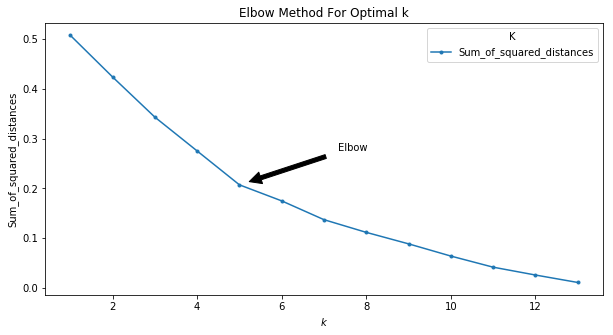

In [79]:
stpaul_grouped_clustering = stpaul_grouped.drop('Zipcode', 1)


K = range(1, 14)
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(stpaul_grouped_clustering)
                for k in K]
Sum_of_squared_distances = [model.inertia_ for model in kmeans_per_k]

# plot the K
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
optimal_k.plot(kind = 'line', figsize = (10, 5), marker = '.')
plt.annotate('Elbow',
             xy=(5, Sum_of_squared_distances[4]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.xlabel('$k$')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Another approach is to use _silhouette score_ (mean of the _silhouette coefficient_ over all the instances). 

In [73]:
silhouette_scores = [silhouette_score(stpaul_grouped_clustering,
                                      model.labels_)
                     for model in kmeans_per_k[1:]]

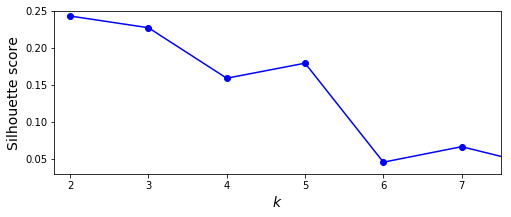

In [84]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 14), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 7.5, 0.03, 0.25])
plt.show()

The best K value seems to be 5 for our datasets.  

Run the k-means into 5 clusters:

In [85]:
# set number of clusters
kclusters = 5

stpaul_grouped_clustering = stpaul_grouped.drop('Zipcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(stpaul_grouped_clustering)

In [87]:
neighborhoods_venues_sorted['Zipcode']=neighborhoods_venues_sorted['Zipcode'].astype(int)
stpaul_merged = zipStPaul
stpaul_merged['zipcode']=stpaul_merged['zipcode'].astype(int)

In [88]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge zipStPaul with neighborhoods_venues to add latitude/longitude for each neighborhood
stpaul_merged = stpaul_merged.join(neighborhoods_venues_sorted.set_index('Zipcode'), on='zipcode')

stpaul_merged.head() 

,zipcode,med_income,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,55101,40300,44.95,-93.09,1,Brewery,Dog Walkers,Bar,Pizza Place,Liquor Store,Farmers Market,Sandwich Place,Hotel,New American Restaurant,Asian Restaurant
1,55102,46255,44.93,-93.12,1,Bar,Italian Restaurant,American Restaurant,Park,Café,Veterinarians,Mexican Restaurant,Coffee Shop,French Restaurant,Theater
2,55103,28899,44.97,-93.13,4,Zoo Exhibit,Garden,Vietnamese Restaurant,Lake,Pet Training,Noodle House,Park,Theme Park,Liquor Store,Farmers Market
3,55104,44629,44.96,-93.17,1,Coffee Shop,Vietnamese Restaurant,Pet Sitting,Gym,Breakfast Spot,Korean Restaurant,Pizza Place,Brewery,Burger Joint,Café
4,55105,76472,44.93,-93.16,1,Coffee Shop,Bakery,Pizza Place,Liquor Store,Italian Restaurant,Ice Cream Shop,Pet Groomers,Pub,Café,Restaurant


Visualizing the clusters:

In [89]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stpaul_merged['latitude'], stpaul_merged['longitude'], stpaul_merged['zipcode'], stpaul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [90]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 0, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,55114,38861,Brewery,Coffee Shop,Record Shop,Trail,Breakfast Spot,Middle Eastern Restaurant,Music Store,Organic Grocery,Scenic Lookout,Bakery


``Cluster 1`` is located in 55114 zipcode, which can be categorized as the [St. Anthony](https://www.unitedstateszipcodes.org/55114) neighborhood. It does not seem to be a good place to open a new pet store, with low median income value without any sign of other pet related categories in the 10 most common venues. 

#### Cluster 2

In [91]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 1, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,55101,40300,Brewery,Dog Walkers,Bar,Pizza Place,Liquor Store,Farmers Market,Sandwich Place,Hotel,New American Restaurant,Asian Restaurant
1,55102,46255,Bar,Italian Restaurant,American Restaurant,Park,Café,Veterinarians,Mexican Restaurant,Coffee Shop,French Restaurant,Theater
3,55104,44629,Coffee Shop,Vietnamese Restaurant,Pet Sitting,Gym,Breakfast Spot,Korean Restaurant,Pizza Place,Brewery,Burger Joint,Café
4,55105,76472,Coffee Shop,Bakery,Pizza Place,Liquor Store,Italian Restaurant,Ice Cream Shop,Pet Groomers,Pub,Café,Restaurant
5,55106,42686,Mexican Restaurant,Park,Bar,Veterinarians,Chinese Restaurant,Pizza Place,Pet Groomers,Coffee Shop,Organic Grocery,Pet Sitting
7,55108,56994,American Restaurant,Snack Place,Sandwich Place,Italian Restaurant,Veterinarians,Coffee Shop,Park,Café,Campground,Scandinavian Restaurant
12,55113,61113,Veterinarians,Pizza Place,American Restaurant,Chinese Restaurant,Pet Stores,Sandwich Place,Park,Coffee Shop,Italian Restaurant,Bakery
15,55116,61142,Park,American Restaurant,Scenic Lookout,Veterinarians,Liquor Store,Mexican Restaurant,Trail,Coffee Shop,Italian Restaurant,Pet Store
16,55117,44040,Veterinarians,Sandwich Place,Fast Food Restaurant,Bar,Chinese Restaurant,American Restaurant,Grocery Store,Video Store,Gym / Fitness Center,Furniture / Home Store
18,55119,56275,Fast Food Restaurant,Video Store,Pizza Place,Hotel,Chinese Restaurant,Veterinarians,Coffee Shop,ATM,Department Store,Shoe Store


`Cluster 2` has Dog Walkers, Veterinarians, Pet Sitting, Pet Groomers, and Pet Stores as part of their top 10 most common categories. 

From the list, I can recommend opening up a new pet store from **55105** zip code, which is located in the [Macalester-Groveland neighborhood](https://www.unitedstateszipcodes.org/55105/). It has a high median income and there is no mention of pet store in the top 10 most common venues in the area. 

The second place that I would recommend is the **55108** zip code, which is located near the [Falcon Heights area](https://www.unitedstateszipcodes.org/55108/). It has a slightly lower median income, but there are already veterinarians as the top 10 most common venues in this neighborhood.

The third place that I would recommend is the **55119** zip code, which is located in the [Battle Creek neighborhood](https://www.unitedstateszipcodes.org/55119/). It has a similar feature as the **55108** location.

#### Cluster 3

In [92]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 2, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,55130,30092,American Restaurant,Liquor Store,Italian Restaurant,Pet Training,History Museum,Gastropub,Park,Pet Sitting,Dog Run,Restaurant


``Cluster 3`` is located in 55130 zipcode, which can be categorized as the [Payne-Phalen](https://www.unitedstateszipcodes.org/55107) neighborhood. It does not seem to be a good place to open a new pet store, with low median income value and having Pet Training, Pet Sitting, and Dog Run already in the top 10 most common venue. They signal a saturated neighborhood to open a Pet Store.

#### Cluster 4

In [93]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 3, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,55107,44913,Mexican Restaurant,Pet Groomers,Automotive Shop,Burrito Place,Taco Place,Park,Scenic Lookout,Brewery,Pet Training,Harbor / Marina


``Cluster 4`` is located in 55107 zipcode, which can be categorized as the [West End](https://www.unitedstateszipcodes.org/55107) neighborhood. It does not seem to be a good place to open a new pet store, with having both Pet Training and Pet Groomers already in the top 10 most common venue. Pet Groomers usually sell similar items that are the same as Pet Stores on top of their grooming business.

#### Cluster 5

In [94]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 4, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,55103,28899,Zoo Exhibit,Garden,Vietnamese Restaurant,Lake,Pet Training,Noodle House,Park,Theme Park,Liquor Store,Farmers Market


``Cluster 5`` is located in 55103 zipcode, which can be categorized as the [North End](https://www.unitedstateszipcodes.org/55103) neighborhood. It does not seem to be a good place to open a new pet store, with low median income.

### Dig deeper into the Three Clusters

I picked: 55105, 55108, and 55119 as the three best zip codes to open a new pet store. Let's look at the data on what is available in the area. 

- 55105: [Macalester-Groveland neighborhood](https://www.unitedstateszipcodes.org/55105/)

In [96]:
zipcode55105 = combined_df[combined_df['Venue Zipcode']==55105]
zipcode55105[zipcode55105['Venue Category'].isin(catInt + list(set(catInt2) - set(catInt)))]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
252,Dog Days Daycare & Boarding - Grand Ave,55105,44.939774,-93.174835,Pet Training
253,Animal Medical Clinic,55105,44.934563,-93.166825,Veterinarians
254,Grand Avenue Veterinary Center,55105,44.939693,-93.148247,Veterinarians
255,Grand Groomers,55105,44.939659,-93.140472,Pet Groomers
262,Bubbly Paws,55105,44.940280,-93.140160,Pet Groomers


Check on the grocery and supermarket in the area:

In [97]:
zipcode55105[zipcode55105['Venue Category'].isin(['Grocery Store','Supermarket'])]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
190,Kowalski's Market,55105,44.940270,-93.153639,Grocery Store
228,Trader Joe's,55105,44.926666,-93.146004,Grocery Store


There is no pet store competitor for this area, with two veterinary center / animal medical center that might sell pet related items. Moreover, there are two grocery stores that do sell pet related items in their shelves. This area can be a very good location to open up a new pet store, if the type of items sold in the pet stores are different enough than the ones sold in grocery stores.
- 55108: [Falcon Heights area](https://www.unitedstateszipcodes.org/55108/)


In [105]:
zipcode55108 = combined_df[combined_df['Venue Zipcode']==55108]
zipcode55108[zipcode55108['Venue Category'].isin(catInt + list(set(catInt2) - set(catInt)))]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
346,Raptor Center,55108,44.982871,-93.181639,Veterinarians
347,Animal Humane Society - St. Paul,55108,44.974723,-93.154704,Animal Shelters
354,University of Minnesota Veterinary Medical Center,55108,44.982202,-93.181925,Veterinarians


Check on the grocery and supermarket category:

In [106]:
zipcode55108[zipcode55108['Venue Category'].isin(['Grocery Store','Supermarket'])]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
342,Tim & Tom's Speedy Market,55108,44.981728,-93.195084,Grocery Store


We did not see any pet store in this zip code. Plus, the [Tim & Tom's Speedy Market](https://timandtomsspeedymarket.com/) is a specialty grocery store that do not sell pet related items. A close contender in terms of a good location to open up a new pet store.  

- 55119: [Battle Creek neighborhood](https://www.unitedstateszipcodes.org/55119/)

In [103]:
zipcode55119 = combined_df[combined_df['Venue Zipcode']==55119]
zipcode55119[zipcode55119['Venue Category'].isin(catInt + list(set(catInt2) - set(catInt)))]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
591,Scenic Hills Animal Hospital,55119,44.948980,-93.018270,Veterinarians
592,Funtastic K9 Training,55119,44.949660,-93.017220,Pet Training
593,Century Animal Clinic,55119,44.966652,-92.985361,Veterinarians
600,Battle Creek Dog Park,55119,44.939410,-93.001641,Dog Run


Check on the grocery and supermarket category:

In [104]:
zipcode55119[zipcode55119['Venue Category'].isin(['Grocery Store','Supermarket'])]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
608,Aldi Food Market,55119,44.950548,-93.015737,Grocery Store


We did not see any pet store in this zip code, but there are two veterinarians hospitals, where they can potentially sell food and toys for their patients. They also have Aldi grocery store in their area. It is still a great area to have a pet store since the Battle Creek Dog Park is in this neighborhood. 